# Project Time Estimation

Main focus of the project is to estimate total time which is needed to complete a fire technical documentation project. 

About dataset: There are data for every project that I have conducted at my job as a fire technical consultant in civil engineering. Most of the fire technical documentation projects were small or medium-sized.

### Datasets consist of following features:
 - name: name of the project
 - time: time needed to coplete the project (source: Toggl)
 - price: price for each project
 - system: link to the main fire technical documentation feature describing constructions, 1 - non-flammable, 2 - mixed, 3 - non-flammable
 - height: Fire height of the building - measured from the floor of first flor up to the floor of the last floor
 - area: Area of focus in m2
 - area_floor_total: total floor area in m2
 - area_floor_drawings: area in m2 which is being drawn
 - num_of_floors: number of floors in total
 - change - feature describing whether the new building is beeing assesed or the old one. Feature also express the magnitude of change, 1 - small changes in any building, 2 - medium-sized changes in old building, 3 - large-sized changes in old buildings, 4 - medium or large changes in new buildings (1977 or later)
 - num_sections: number of fire sections in the building
 - num_special: number of special calculations in the assesment (fire separations, detailed calculations etc.)
 - block_plan: logical value whether the project has a block plan conducted
 - n_drawings: number of drawings other than block plan
 
#### Main focus
 - Main focus is to estimate time which is needed to conduct a fire technical documentation project. 
 - Regression will be used during the project


In [2]:
# Import libraries
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
# Read and show dataset
file = '.\data\zakazky_data.csv'
df = pd.read_csv(file)
print(df.head())

                   name                       time  price  system  height  \
0         18-005_Hýskov  1 days 10:06:08.000000000  30000       1    5.80   
1      18-078_RD Řicany  0 days 04:29:44.000000000   3500       1    3.22   
2  19-001_Garáž Spořice  0 days 02:59:40.000000000   2500       2    0.00   
3  19-002_Garáž Chrlice  0 days 05:31:13.000000000   2500       1    0.00   
4       19-004_RD Tater  0 days 04:03:18.000000000   2500       3    3.29   

      area  area_floor_total  area_floor_drawings  num_of_floors  change  \
0  1308.81           2946.98              2946.98              4       0   
1   260.00            430.20                89.50              2       0   
2    62.00             44.99                44.99              1       0   
3    69.25             54.89                54.89              1       0   
4    70.95            105.39               105.39              3       2   

   num_sections  num_special  block_plan  n_drawings  
0            93          

In [4]:
# Converting time from string to time in seconds
df['time'] = pd.to_timedelta(df['time'])
df['time'] = df['time'].apply(lambda x: x.total_seconds())

### Creating new features

There is one feature in particular in current dataset which is biased and it is the number of technical drawings (n_drawnings). The complexity of technical drawing can differ enourmosly from project to project. For instance, technical drawing for a family house is much less complex then drawing for a hospital. Drawing complexity feature is therefore introduced below.

It is considered that complexity of drawings is the function of the area which needed to be drawn. Area_floor_drawings are therefore divided by the number of drawings (n_drawings). Block_plan feature also adds to the drawing complexity. Complexity of the block_plan drawing can be based on experience considered as equal to all kinds of projects. It was selected that one block plan drawing adds to the total drawing complexity of the project 200 points.


In [5]:
def drawing_complexity(row):
    if row['n_drawings'] == 0:
        if row['block_plan'] > 0:
            complexity = row['block_plan'] * 50
        else:
            complexity =0
    if row['n_drawings'] > 0:
        if row['block_plan'] > 0:
            complexity = (row['area_floor_drawings'] / row['n_drawings']) + (row['block_plan'] * 50)
        else:
            complexity = (row['area_floor_drawings'] / row['n_drawings'])
    return complexity

df['drawing_complexity'] = df.apply(lambda row: drawing_complexity(row),axis=1)

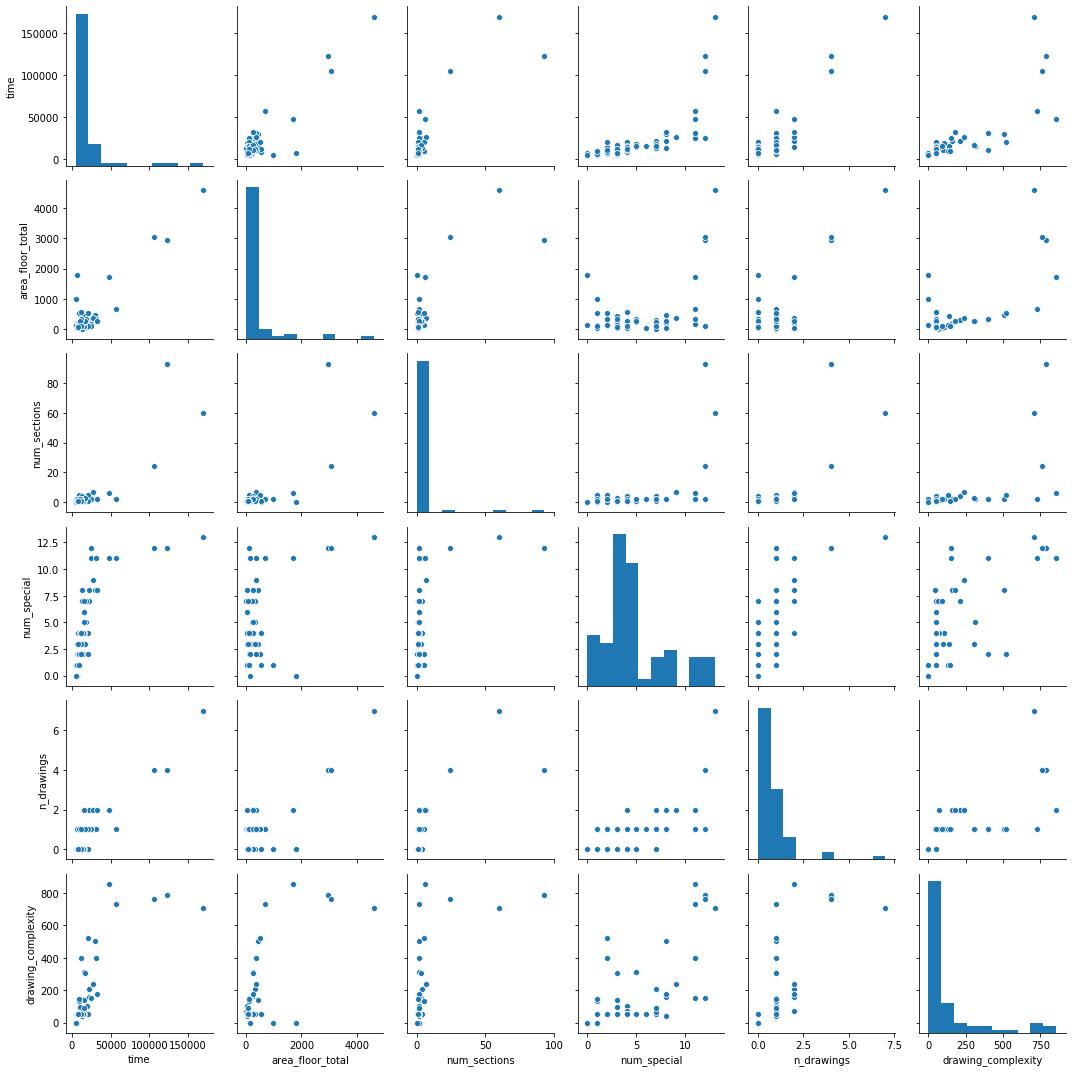

In [6]:
# Visualising selected feature
cols = ['time', 'area_floor_total', 'num_sections', 'num_special', 'n_drawings', 'drawing_complexity']
sns.pairplot(df[cols], height=2.5)
plt.tight_layout()
plt.show()

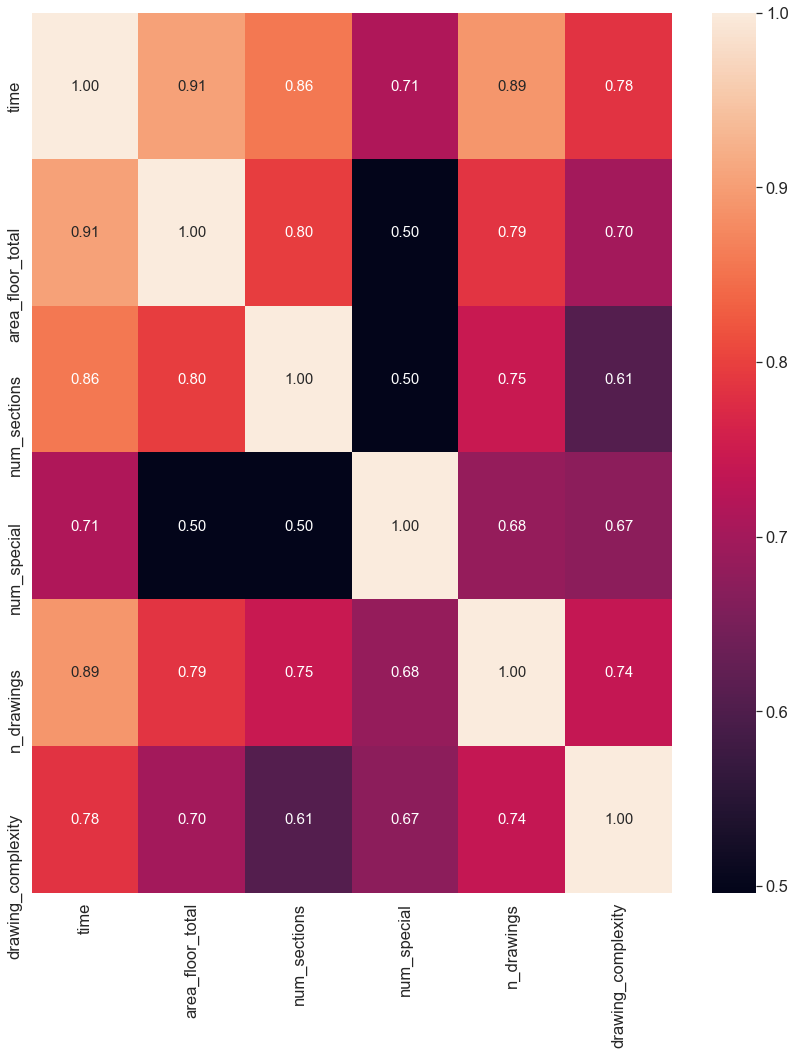

In [7]:
# Correlation matrix
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(12,15))

hm = sns.heatmap(cm,
                 cbar=True,
                 annot=True,
                 fmt='.2f',
                 annot_kws={'size': 15},
                 yticklabels=cols,
                 xticklabels=cols)
ax.set_ylim(len(cm), -0)
plt.tight_layout()
plt.show()

Accoring to correlation matrix time correlates with num_special, num_secitons and n_drawings. Price is not selected as it is the feature which is determined from the time

In [8]:
# Select working features
cols_selected = ['time', 'area_floor_total', 'num_sections', 'num_special', 'drawing_complexity', 'change']
df_sel = df[cols_selected]

### Outliers selection

There are insufficient number of large scale projects in the datasets. Data from these few projects are therefore examined whether they are outliers or not. Z-score for each datapoint is therefore conducted further.

In [9]:
from scipy import stats
df_sel_red = df_sel[(np.abs(stats.zscore(df_sel)) < 3).all(axis=1)]
i_max = df_sel_red['time'].idxmax()
df_sel_red = df_sel_red.drop([i_max])

# Not used


### Linear regression model

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [11]:
class regression_model(object):
    ''' Regression model 
            data = pandas df - dataframe with examined features
            selected = list - selected features from the dataframe
            deg = int - represents degree of polynomial function, 1 - linear
            t_size = float - size of the training size
    ''' 
    def __init__(self, data, selected, deg, t_size):
    
        self.data = data 
        self.selected = selected
        self.deg = deg
        self.t_size = t_size
        
    def data_preparation(self):
        '''Function for data preparation'''
        # Preparing data
        X = self.data[self.selected].values
        y = self.data['time'].values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.t_size, random_state=1)
        
        # Setting up models
        poly_features_test_train = PolynomialFeatures(degree=self.deg)

        # Transform features to higher degree
        self.X = X
        self.y = y
        self.X_train_poly = poly_features_test_train.fit_transform(X_train)
        self.X_train = X_train
        self.X_test = X_test
        self.y_test = y_test
        self.y_train = y_train 
    
    def linear(self):
        self.data_preparation()
        '''Function setting up the linear regression model, MSE a R2 are printed'''
        poly_features = PolynomialFeatures(degree=self.deg)
        lr = LinearRegression() # model for fitting test and train data
        lr.fit(self.X_train_poly, self.y_train) # Train on train data
        
        y_train_pred = lr.predict(self.X_train_poly)
        y_test_pred = lr.predict(poly_features.fit_transform(self.X_test))
          
        print('Data splitted to train and test data with test size {}%'.format(self.t_size * 100))
        print('MSE train: %.3f, test: %.3f' % (
            mean_squared_error(self.y_train, y_train_pred),
            mean_squared_error(self.y_test, y_test_pred)))
        print('R^2 train: %.3f, test: %.3f' % (
            r2_score(self.y_train, y_train_pred),
            r2_score(self.y_test, y_test_pred)))
        self.lr = lr
        self.y_train_pred = y_train_pred
        self.y_test_pred = y_test_pred
        
    def fitted_plot(self):
        '''Function plots the scatter plot with fitted curve. Functional only for one feature.'''
        poly_features = PolynomialFeatures(degree=self.deg)
        X_fit = np.arange(self.X.min(),self.X.max()+1,1)[:,np.newaxis]
        y_quad_fit = self.lr.predict(poly_features.fit_transform(X_fit))
        
        fig1 = plt.figure(figsize=(8,6))
        plt.scatter(self.X, self.y, s=50)
        plt.plot(X_fit, y_quad_fit, color='red')
        plt.ylabel('Time in seconds')
        plt.show()
        
    def estimate_simple_feature_time(self, input_data):
        '''Function predicts time of the project based on input given.'''
        poly_features = PolynomialFeatures(degree=self.deg)  
        X_new = np.array(input_data).reshape(1, -1)
        time_std = self.lr.predict(poly_features.fit_transform(X_new))
        print('Time {} hours'.format((time_std / 60 / 60)[0].round(3)))
        
    def residual_plot(self):
        fig2 = plt.figure(figsize=(8,6))
        plt.scatter(self.y_train_pred,  self.y_train_pred - self.y_train,
                    c='steelblue', marker='o', edgecolor='white',
                    label='Training data', s=50)
        plt.scatter(self.y_test_pred,  self.y_test_pred - self.y_test,
                    c='limegreen', marker='s', edgecolor='white',
                    label='Test data', s=50)
        plt.xlabel('Predicted values')
        plt.ylabel('Residuals')
        plt.legend(loc='upper left')
        plt.hlines(y=0, xmin=-100000, xmax=100000, color='black', lw=2)
        #plt.xlim([-10000, 60000])
        plt.tight_layout()

## Testing of individual features

Below selected features are tested individually. Selected features are ['time', 'area_floor_total', 'num_sections', 'num_special', 'drawing_complexity'].

Above, outliers were eliminated from the dataframe based on Z-score analysis. Tests are conducted for both reduced (df_sel_red) and unreduced (df_sel) data separately.

### Individual feature - area_floor_total 

Data splitted to train and test data with test size 40.0%
MSE train: 155679159.767, test: 84908034.397
R^2 train: 0.828, test: 0.757
Time 3.74 hours


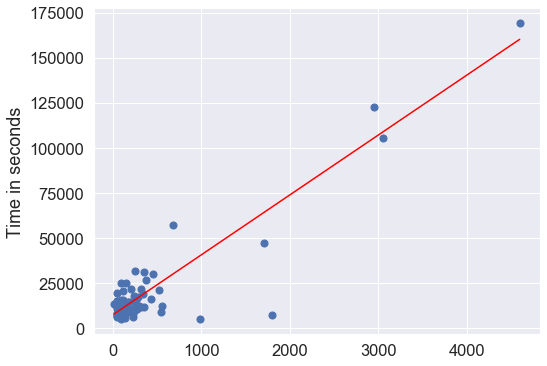

In [12]:
# Unreduced data 
floor_total = regression_model(df_sel, ['area_floor_total'], 1, 0.4)
floor_total.linear()
floor_total.estimate_simple_feature_time([180])
floor_total.fitted_plot()

#### Insight 

Two datapoints have recorded suspicesely low time investments and has huge floor area indicating that complexity level in these particular projects is very low. Complexity of the project can be observed by the change feature.

Change feature equals to 1 indicates the low comlexity of the project. Other values (2,3,4) ought to have similar level of complexity.

Total floor area in the projects where the change feature is equal to 1 is therefore penalised by the coefficent 0.1.

In [13]:
df_sel['area_floor_total'] = df_sel.apply(lambda row: row['area_floor_total'] * 0.1 
                                                  if row['change'] == 1
                                                  else row['area_floor_total'], axis=1)

C:\Users\Honza\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Data splitted to train and test data with test size 40.0%
MSE train: 50053656.704, test: 62453219.937
R^2 train: 0.945, test: 0.821
Time 4.116 hours


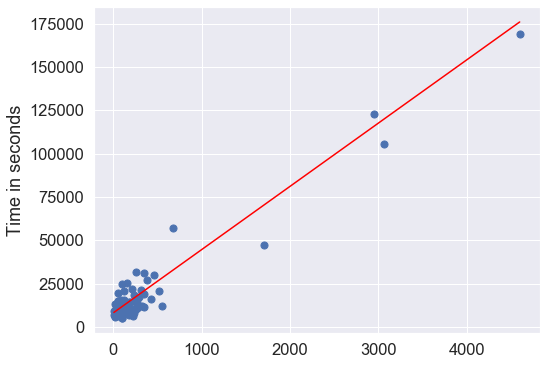

In [14]:
floor_total = regression_model(df_sel, ['area_floor_total'], 1, 0.4)
floor_total.linear()
floor_total.estimate_simple_feature_time([180])
floor_total.fitted_plot()

### Individual feature - num_sections

Data splitted to train and test data with test size 40.0%
MSE train: 205477509.118, test: 153189480.433
R^2 train: 0.774, test: 0.561
Time 4.216 hours


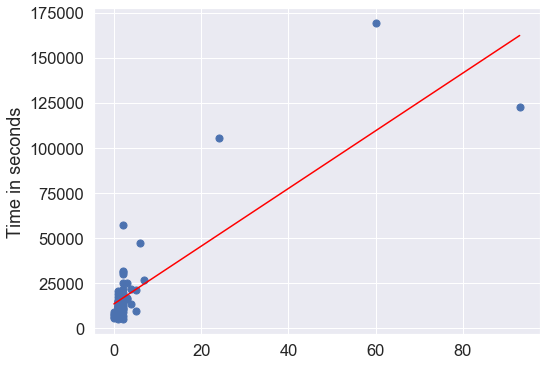

In [15]:
# Linear
sections = regression_model(df_sel, ['num_sections'], 1, 0.4)
sections.linear()
sections.estimate_simple_feature_time([1])
sections.fitted_plot()

Data splitted to train and test data with test size 40.0%
MSE train: 77572719.985, test: 46334412.353
R^2 train: 0.915, test: 0.867
Time 3.457 hours


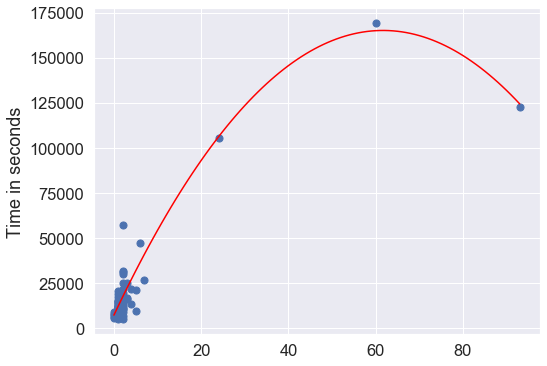

In [16]:
# Second polynomial
sections = regression_model(df_sel, ['num_sections'], 2, 0.4)
sections.linear()
sections.estimate_simple_feature_time([1])
sections.fitted_plot()

### Insight 



### Individual feature - num_special 

Data splitted to train and test data with test size 40.0%
MSE train: 482122591.655, test: 124628100.156
R^2 train: 0.469, test: 0.643
Time 2.837 hours


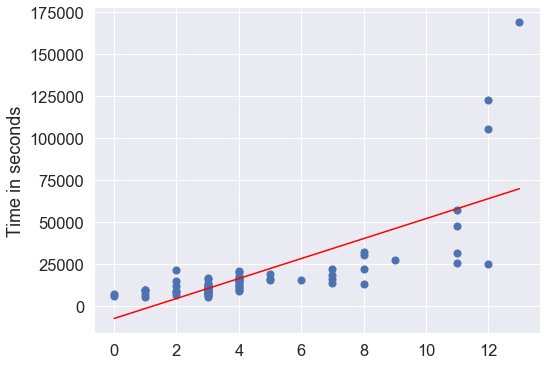

In [17]:
# Linear regression
speacial = regression_model(df_sel, ['num_special'], 1, 0.4)
speacial.linear()
speacial.estimate_simple_feature_time([3])
speacial.fitted_plot()

Data splitted to train and test data with test size 40.0%
MSE train: 246739190.021, test: 36015781.126
R^2 train: 0.728, test: 0.897
Time 3.956 hours


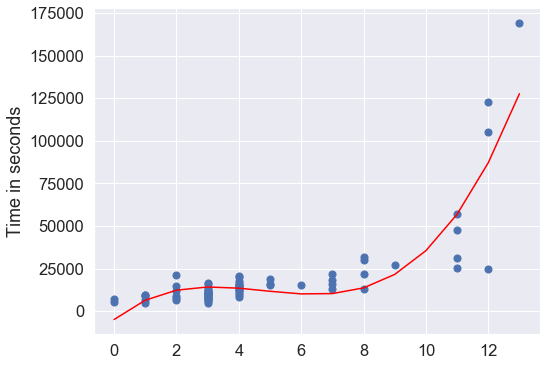

In [18]:
# Third polynomial regression
speacial = regression_model(df_sel, ['num_special'], 3, 0.4)
speacial.linear()
speacial.estimate_simple_feature_time([3])
speacial.fitted_plot()

### Individual feature - drawing_complexity

Data splitted to train and test data with test size 40.0%
MSE train: 323336295.237, test: 214482053.406
R^2 train: 0.644, test: 0.386
Time 7.455 hours


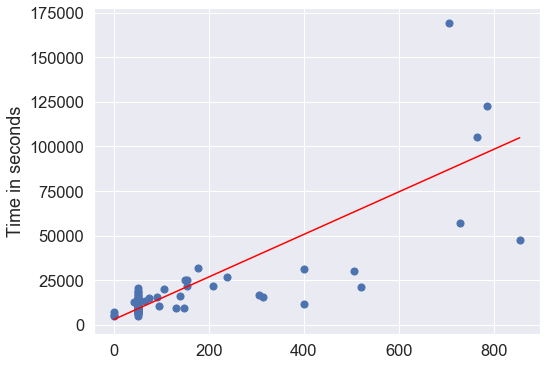

In [19]:
# Linear regression
drawing = regression_model(df_sel, ['drawing_complexity'], 1, 0.4)
drawing.linear()
drawing.estimate_simple_feature_time([200])
drawing.fitted_plot()

Data splitted to train and test data with test size 40.0%
MSE train: 226332383.184, test: 644955651.342
R^2 train: 0.751, test: -0.848
Time 5.765 hours


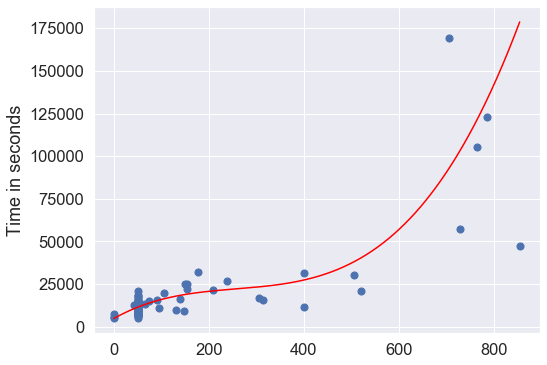

In [20]:
# Polynomial regression
drawing = regression_model(df_sel, ['drawing_complexity'], 3, 0.4)
drawing.linear()
drawing.estimate_simple_feature_time([200])
drawing.fitted_plot()

### Multiple linear regression

featuring: num_sections, num_special and n_drawings

In [21]:
# Dropping unused change column
df_sel2 = df_sel.drop('change', axis=1)
columns_used = list(df_sel2.columns)
columns_used.pop(0)

print(columns_used)

['area_floor_total', 'num_sections', 'num_special', 'drawing_complexity']


Data splitted to train and test data with test size 40.0%
MSE train: 12505057.803, test: 67694966.330
R^2 train: 0.986, test: 0.806


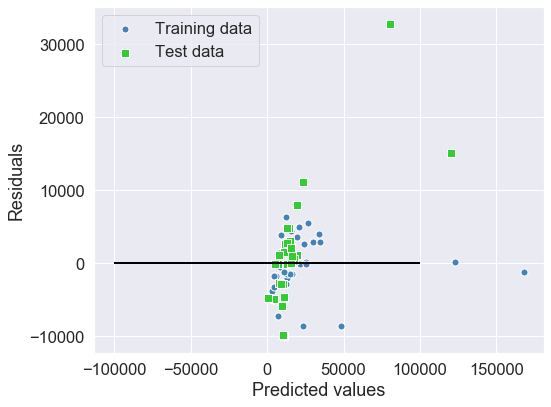

In [22]:
multiple_linear = regression_model(df_sel, columns_used, 1, 0.4)
multiple_linear.linear()
multiple_linear.residual_plot()

Data splitted to train and test data with test size 40.0%
MSE train: 5036502.121, test: 1095418446.217
R^2 train: 0.994, test: -2.138


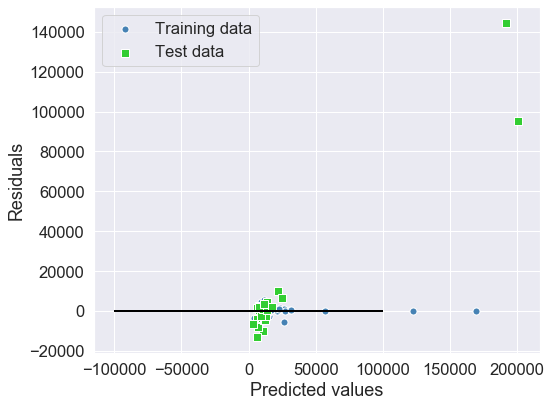

In [23]:
multiple_polynomial = regression_model(df_sel, columns_used, 2, 0.4)
multiple_polynomial.linear()
multiple_polynomial.residual_plot()

In [24]:
# ['area_floor_total', 'num_sections', 'num_special', 'drawing_complexity']
area_floor_total_input = 156.9
num_sections_input = 2
num_special_input = 5
n_block_sections_input = 1
n_drawings_input = [0, 0] # [number of drawings, area in m2]

if n_drawings_input[0] == 0:
    if n_block_sections_input > 0:
        complexity_input = n_block_sections_input * 50
    else:
        complexity_input = 0
if n_drawings_input[0] > 0:
    if n_block_cestions_input > 0:
        complexity_input = n_block_sections_input * 50 + n_drawings_input[0] * n_drawings_input[1]
    else:
        complexity_input = n_drawings_input[0] * n_drawings_input[1]

# ['time', 'area_floor_total', 'num_sections', 'num_special', 'drawing_complexity'].
multiple_linear.estimate_simple_feature_time([area_floor_total_input, num_sections_input, num_special_input, complexity_input])

Time 3.846 hours
